# HW_2

Импорт необходимых библиотек

In [232]:
!pip install numpy pandas matplotlib tqdm ipywidgets scikit-learn shap lime > nul

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import permutation_importance
import shap
from lime import lime_tabular

%matplotlib inline

Функция для вычисления средней абсолютной процентной ошибки (MAPE)

In [202]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Для анализа выбран временной ряд **данных об осадках**.

In [203]:
df_rainfall = pd.read_csv("./no_track/rainfall.csv",
                          index_col=['date'],
                          parse_dates=['date']
                          )
df_rainfall.head(10)

,mean_rainfall
date,
1990-01-01,1.613
1990-01-11,1.557
1990-01-21,2.219
1990-02-01,4.788
1990-02-11,6.510
1990-02-21,4.513
1990-03-01,6.793
1990-03-11,7.497
1990-03-21,13.219


Ресемплирование данных по месяцам, вычисление средних значений и удаление строк с пропущенными значениями

In [204]:
df_rainfall = df_rainfall.resample('M').mean().dropna()
df_rainfall.head(10)

,mean_rainfall
date,
1990-01-31,1.796333
1990-02-28,5.270333
1990-03-31,9.169667
1990-04-30,16.180333
1990-05-31,78.126333
1990-06-30,144.636333
1990-07-31,156.749000
1990-08-31,101.696000
1990-09-30,94.984000


In [205]:
df_rainfall.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 1990-01-31 to 2019-12-31
Freq: ME
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mean_rainfall  360 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


Визуализация ряда

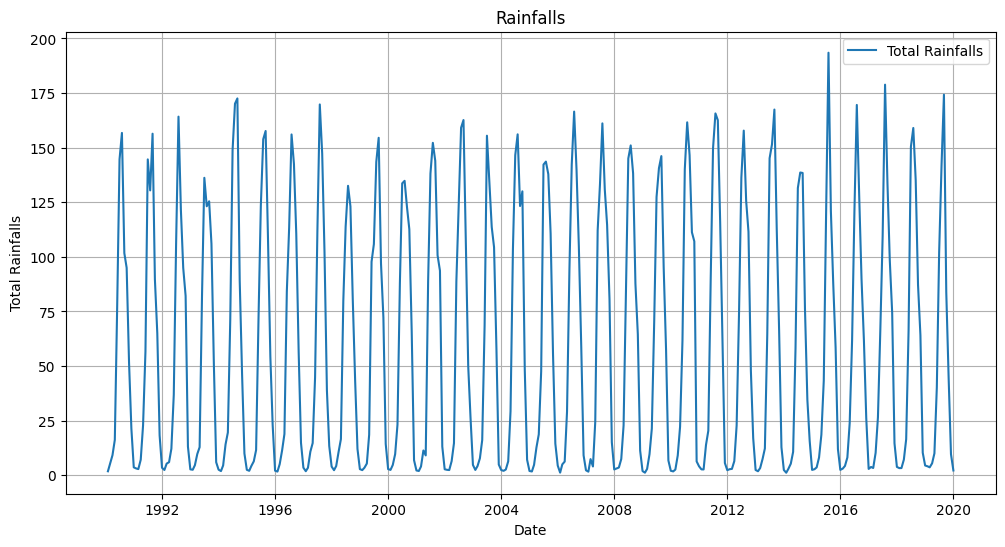

In [206]:
plt.figure(figsize=(12, 6))
plt.plot(df_rainfall.index, df_rainfall['mean_rainfall'], label='Total Rainfalls')
plt.title('Rainfalls')
plt.xlabel('Date')
plt.ylabel('Total Rainfalls')
plt.legend()
plt.grid(True)
plt.show()

**Тренд**: явно не выражен  
**Сезонность**: пристуствует. Осадки растут в первой половине года, достигая масксимума в середине года, и падают во второй половине.  
**Стационарность**: ряд не стационарен, поскольку наблюдается сезонность.

train/test split

In [207]:
def timeseries_train_test_split(df, test_size):

    test_index = int(len(df)*(1-test_size))

    df_train = df.iloc[:test_index]
    df_test = df.iloc[test_index:]

    return df_train, df_test


df_train, df_test = timeseries_train_test_split(df_rainfall, test_size=0.3)

### BaseLine

Построение с помощью скользящего среднего (прогноз на основне информации за последний месяц)

In [208]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(df_train, 3)

74.88077777777778

Валидация

In [209]:
df_test.head(1)

,mean_rainfall
date,
2010-12-31,4.079667


Визуализация, размер окна - 3 месяца

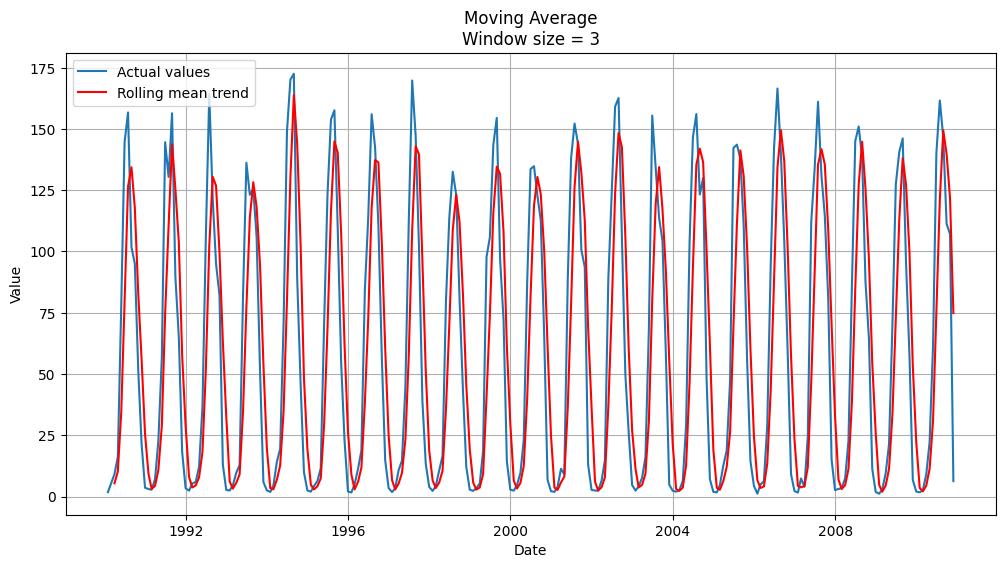

In [210]:
def plot_moving_average(series, window):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series, label='Actual values')
    plt.plot(rolling_mean.index, rolling_mean, 'r', label='Rolling mean trend')
    plt.title('Moving Average\nWindow size = {}'.format(window))
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_moving_average(df_train, 3)

Замеры качества BaseLine

Метрикой избрана **MAE** - средняя абсолютная ошибка

In [211]:
mean_absolute_error([moving_average(df_train, 3)], df_test.head(1))

70.80111111111111

Ошибка достаточно велика

### Статистическая модель

Тест Дики-Фуллера

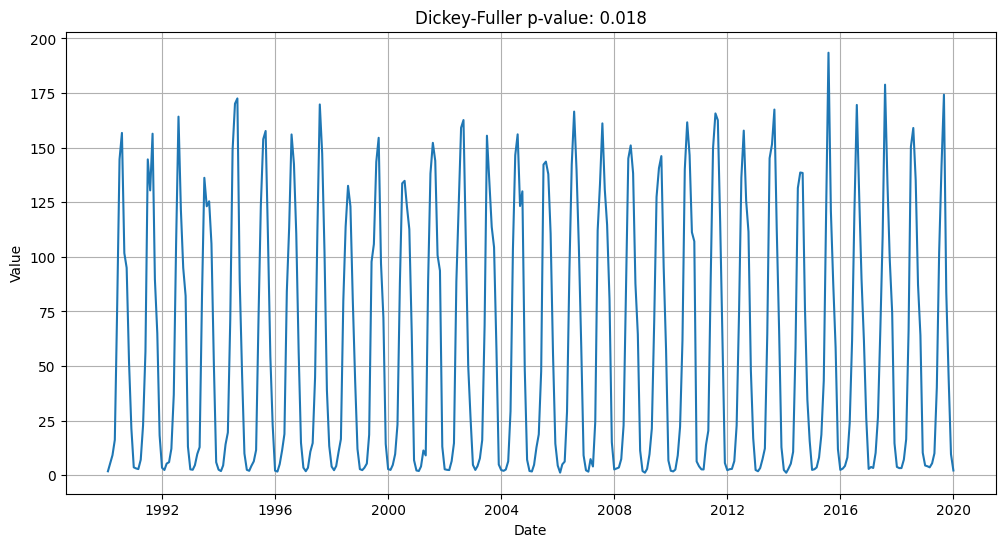

In [212]:
plt.figure(figsize=(12, 6))
plt.plot(df_rainfall.index, df_rainfall)
plt.title("Dickey-Fuller p-value: {}".format(round(sm.tsa.stattools.adfuller(df_train)[1], 3)))
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

Если учитывать то, что этот тест не учитывает сезонность, то на основании довольно малого реультата **p-value** (0.018) можно сказать, что этот ряд стационарен. 

Построение ACF и PACF

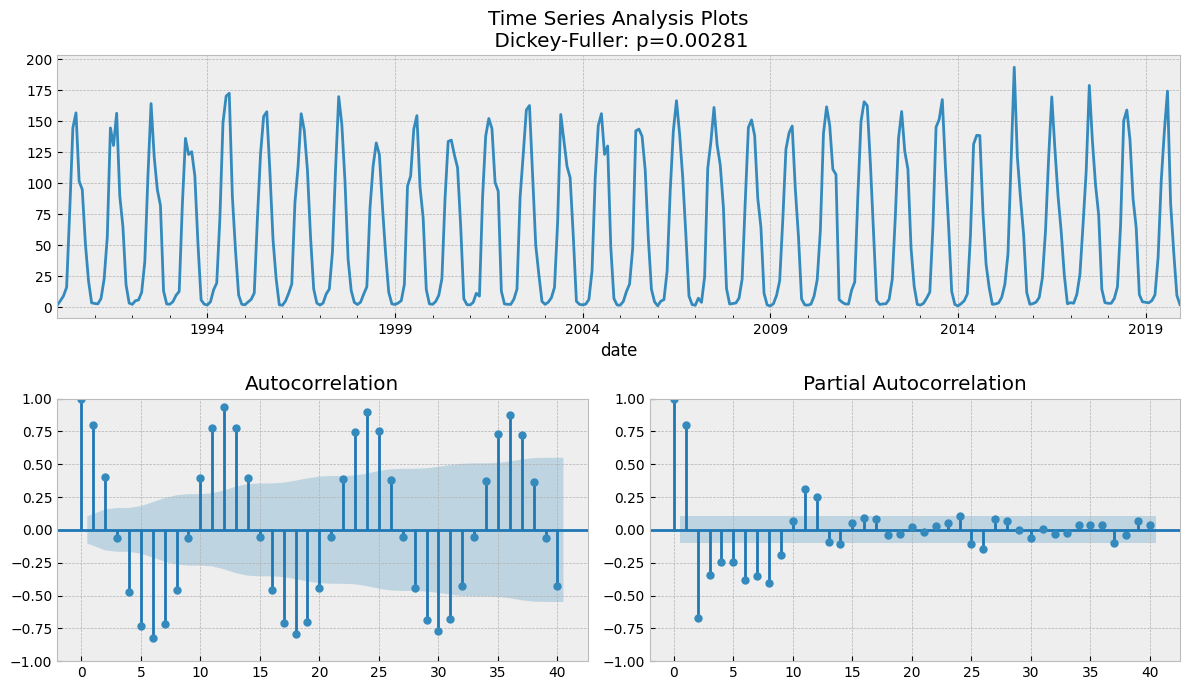

In [213]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(df_rainfall.mean_rainfall, lags=40)

Сезонность 12 лагов - 1 год. Соответсввует первоначальным предположениям. Необходимо вычесть сезонные лаги. 

Сезонное дифференцирование

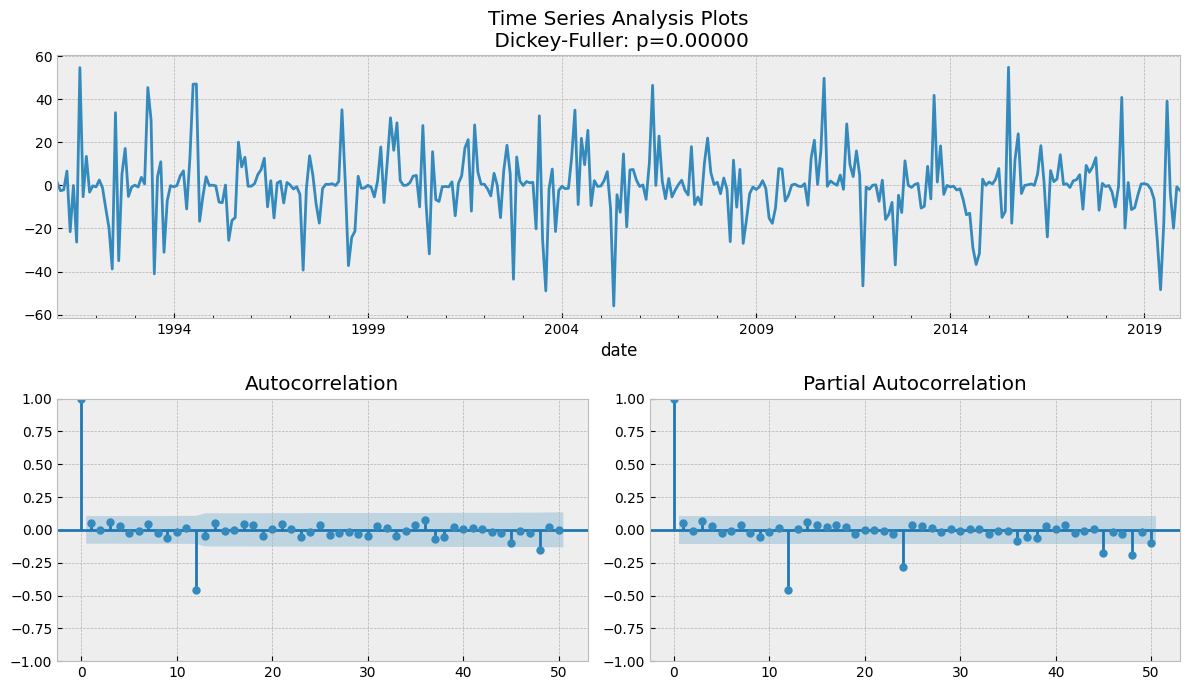

In [214]:
df_diff = df_rainfall.mean_rainfall - df_rainfall.mean_rainfall.shift(12)
tsplot(df_diff[12:], lags=50)

Ряд стал более похож на стационарный.  
12 лаг все еще сильно коррелирует, повторное дифференцирование не дало успеха.  
Оставляем как есть.

Обучение моделей **ARIMA** и **SARIMA**

In [215]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(df.mean_rainfall, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

Параметры

In [216]:
d = 0 # не было обычного дифференцирования
D = 1 # Проводилось сезонное дифференцирование
s = 12 # период - 12 
# Из наблюдений ACF и PACF
ps = range(2, 4)
qs = range(2, 4)
Ps = range(0, 2)
Qs = range(2, 3)


parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [217]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/8 [00:00<?, ?it/s]

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

код не работает, не могу понять в чем дело

### Классическая модель

Создание 36 признаков: лаги одного цикла. Число 36 - оптимальный вариант, поскольку меньшие значение ухудшали рехультат

In [218]:
data = pd.DataFrame(df_rainfall.mean_rainfall.copy())
data.columns = ["y"]

for i in range(1, 37):
    data["lag_{}".format(i)] = data.y.shift(i)

Признак года скорее всего будет ухудшать обучение модели, поэтому создаем только признаки дня и месяца

In [219]:
data['day'] = data.index.day
data['month'] = data.index.month

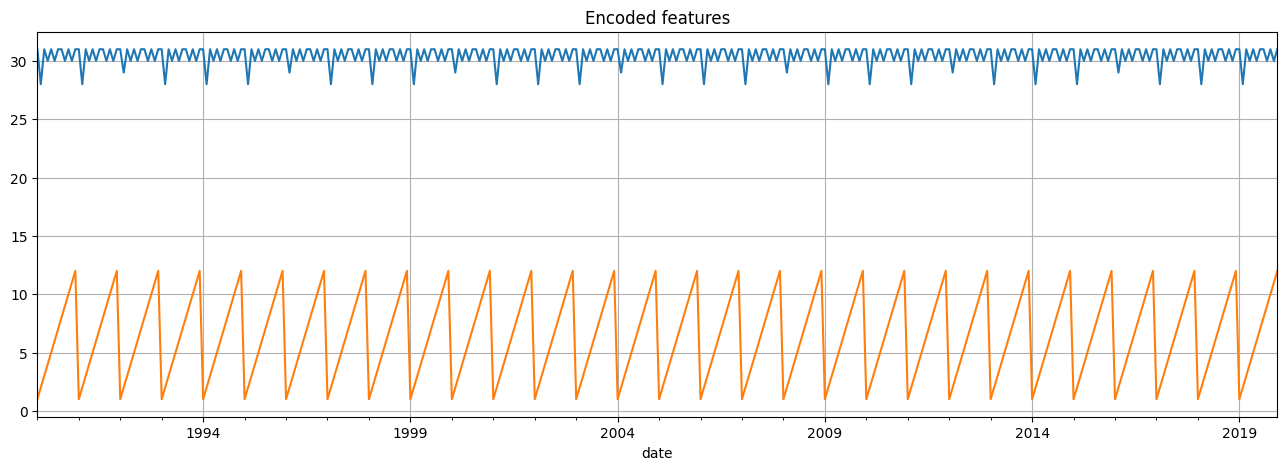

In [220]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.day.plot()
data.month.plot()
#data.year.plot()
plt.grid(True)

**Обучение**

test/train split

In [221]:
def timeseries_train_test_split(X, y, test_size):

    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [222]:
def plotModelResults(model, X_train=X_train, X_test=X_test):

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

Методом проб и ошибок выбраны параметры, дающие лучший результат

In [223]:
regr = RandomForestRegressor(max_depth=6, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, random_state=42)

**Визуализация**

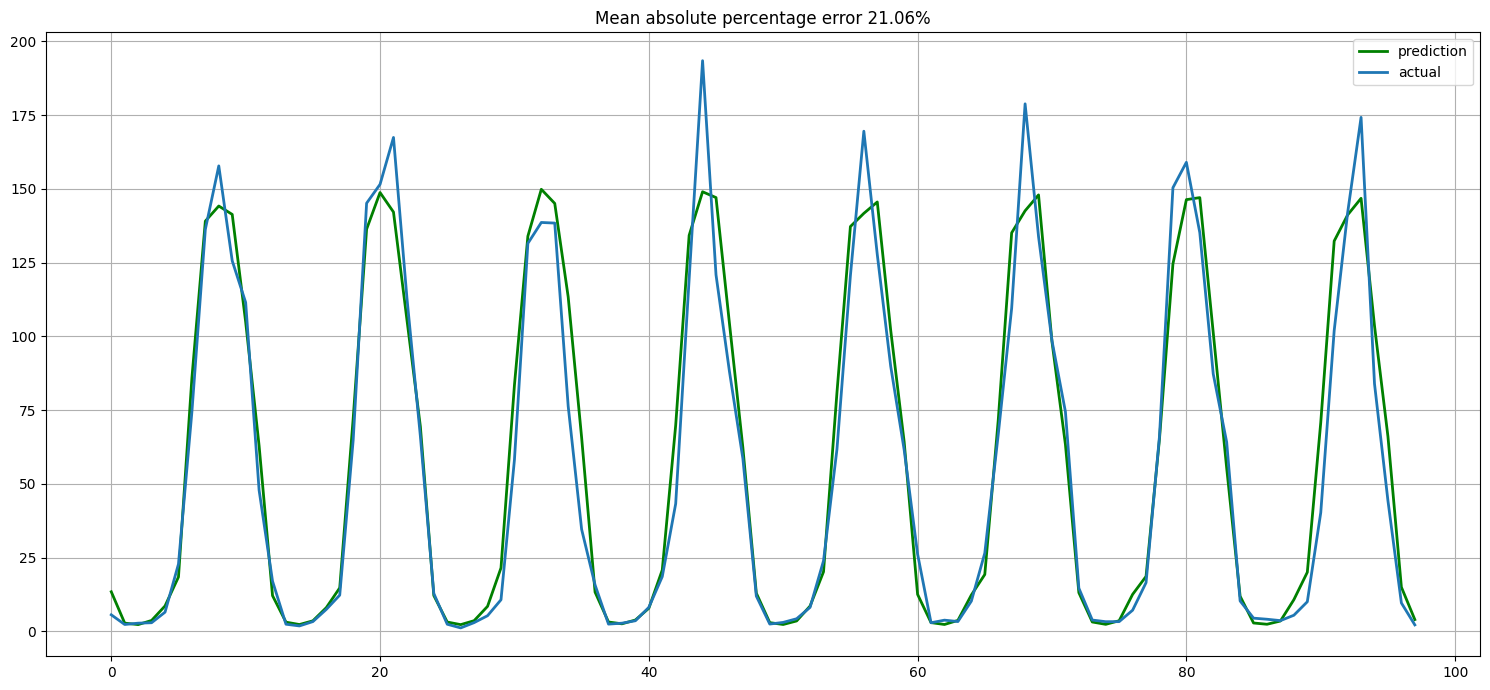

In [224]:
plotModelResults(regr, X_train=X_train, X_test=X_test)

Ошибка составляет 21.06%, что скорее всего связано с сезонными скачками в середине года.

**Интерпретация**

**permutation importance**

Вычисление и визуализация важности признаков с использованием перестановочного метода для модели леса

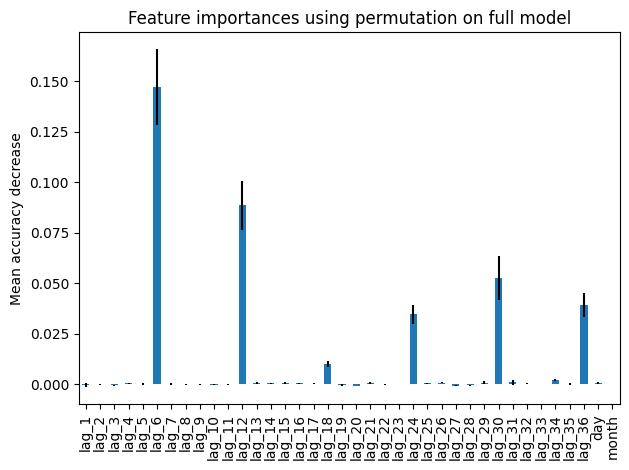

In [225]:
importances = permutation_importance(regr, X_test, y_test, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

**LIME**

In [226]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['rings'],
    verbose=True,
    mode='regression',
)
i = 33
exp = explainer.explain_instance(X_test.iloc[i].values, regr.predict, num_features=5)

Intercept 40.50360842656656
Prediction_local [126.67683012]
Right: 145.07163060270784


Объяснения предсказания модели

In [227]:
exp.show_in_notebook(show_table=True)

In [228]:
exp.as_list()

[('lag_6 <= 4.99', 28.732315990925922),
 ('lag_12 > 112.52', 19.658755386520035),
 ('lag_36 > 112.01', 13.187198180354615),
 ('lag_30 <= 5.14', 12.79014582923355),
 ('lag_24 > 112.52', 11.80480630430716)]

**SHAP** - локальная интерпретация (для одного объекта)

In [229]:
explainer = shap.TreeExplainer(regr)

choosen_instance = X_test.iloc[[33]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [230]:
choosen_instance = X_test.iloc[[27]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

**SHAP** - глобальная интерпретация (для всей модели целиком)

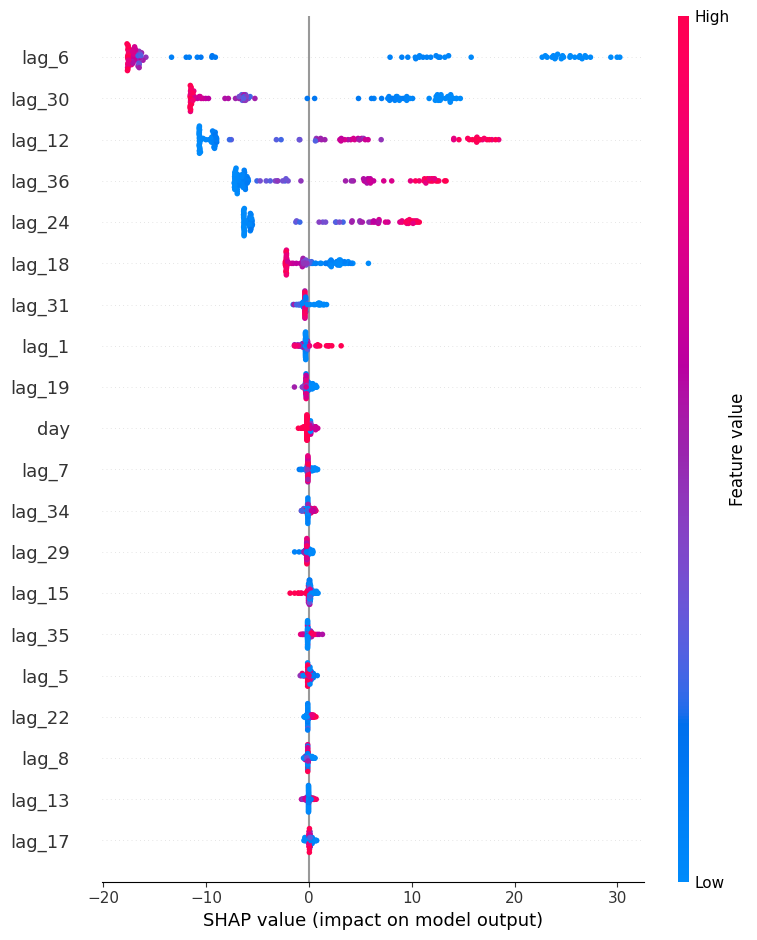

In [231]:
shap_values = explainer.shap_values(X_train.iloc[:100])
shap.summary_plot(shap_values, X_train.iloc[:100])

**Выводы:**  
Судя по результату лаги 6, 30, 12, 36, 24, 18, 1 представляют большую значимость для анализа по сравнению с остальными